## Proof of concept for SIR model

https://www.youtube.com/watch?v=wEvZmBXgxO0

In [1]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt

For Gamma, Sigma, and Beta, the values are effectively equal to 1 / n days. Thus, 0.2 = 1/5, meaning it takes 5 days to become infected. 

In [2]:
I0 = 0.001 ## Starting infection %
S0 = 1 - I0 ## Starting susceptable %
R0 = 0 ## Starting recovered %
beta = 0.2## Infection rate
gamma = 0.1 ## Recovery rate

time = np.linspace(0, 500, 1000) ## Creates 1000 time points between 0 and 500

In [3]:
def SIR(y, t, beta, gamma): ## Defines a formula which sets up the three differentials to be used and outputs the three differentials in an array
    S, I, R = y
    
    dS_dT = -beta*S*I ## Differential equation for change in susceptability over time
    dI_dT = beta*S*I - gamma*I ## Differential for change in Infection over time
    dR_dT = gamma*I ## Differential for change in recovery over time
    
    return([dS_dT, dI_dT, dR_dT]) ## Returns equations in a list from SIR function 

In [4]:
solution = scipy.integrate.odeint(SIR, [S0, I0, R0], time, args=(beta, gamma)) ## Integrates the differential equations over time using the starting parameters and beta and gamma as the arguments 
solution = np.array(solution) ## Turns the values into an array of three columns, one for each equation

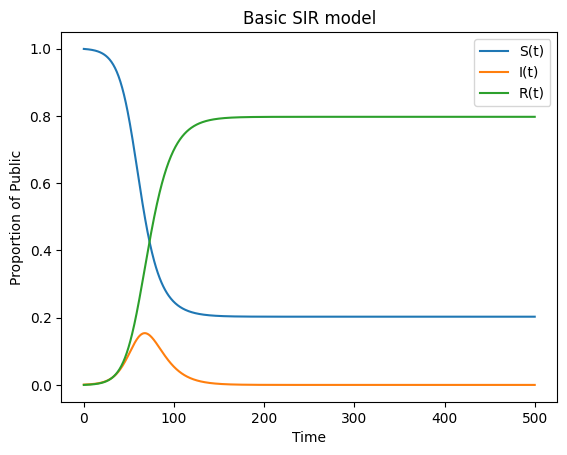

In [5]:
plt.figure
plt.plot(time, solution[:, 0], label="S(t)") ## Plots the integrated dS/dT equation over the time list
plt.plot(time, solution[:, 1], label="I(t)") ## Plots the integrated dI/dT equation over the time list
plt.plot(time, solution[:, 2], label="R(t)") ## Plots the integrated dR/dT equation over the time list
plt.legend() ## Adds the legend with labels to the plot
plt.xlabel("Time")
plt.ylabel("Proportion of Public")
plt.title("Basic SIR model")
plt.savefig('basic_sir_model')
plt.show()


# SEIR Model

## Includes changing E, and adding a lockdown

https://python.quantecon.org/sir_model.html

In [6]:
from scipy.integrate import odeint

In [7]:
## Starting parameters

i_0 = 0.00 ## Strarting infection set to 0%
e_0 = 0.05 ## Starting exposure set to 5%
s_0 = 1 - i_0 - e_0 ## Susceptability is everyone not currently infected or exposed, so 1 - both these

x_0 = s_0, e_0, i_0 ## Creates one variable where each starting probability is listed

gamma = 1/10 ## The recovery rate. The infection lasts 1/n days, thus 1/10 = 10 days.
sigma = 1/14 ## The rate of exposure to infection. There is an incubation period of 1/n days, thus 1/14 = 14 days.
R0 = 2 ## The transmission rate. Each infected will infect 'n' others.

In [8]:
def SEIR(x, t, R0): ## Creates a function which outputs the differential equations required for SEIR models

    ## The x is the input array, which will be some values
    ## t is the time list, which we will create later
    ## R0 is the transmission rate eg 2 (meaning it will spread to two people from each indection)
    s, e, i = x ## Creates three variables for SEIR, each currently equal to x, but will be updated 
                ## using the differentials


    beta = R0 * gamma ## Creates the beta multiplier
    
    ds = -beta*s*i ## Differential for suspeptability over time
    de = beta*s*i - sigma*e ## Differential for new exposure over time
    di = sigma*e - gamma*i ## Differential for new infection over time

    return ds, de, di ## Returns the differential calculations in a list

In [9]:
t_length = 500 ## Sets max time to 500 
instances = 1000 ## Creates 1000 time points
t_vec = np.linspace(0, t_length, instances) ## Creates n time points between 0 and the t_length

## Changing Values of R0

In [10]:
def solve_path(R0, t_vec, x_init=x_0): ## Defines a function taking the R0, time, and starting values

    G = lambda x, t: SEIR(x, t, R0) 
    ## Takes x and t (inputs of SEIR function above) and runs the SEIR function on them with the R0 
    ## value specified
    
    
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose() 
    ## Integrates the SEIR differentials using the starting parameters over the time array, 
    ## and transposes into new variables, one for each part of the SEIR differentials

    c_path = 1 - s_path - e_path
    r_path = 1 - s_path - e_path - i_path
    total = s_path + e_path + i_path + r_path
    ## Creates the 'removed' list by subtracting the exposed, susceptable, and infected from 1 (basically
    ## everyone who isnt left)
    
    return i_path, c_path, s_path, e_path, r_path, total ## Returns all of the lists
    ## Total is calculated to make sure all values S,E,I, and R add up to 1


In [11]:
R0_vals = np.linspace(0.5, 5, 10) ## Creates a list of 10 R0 values between 0 and 5
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths, s_paths, e_paths, r_paths, totals = [], [], [], [], [], [] ## Creates 6 empty arrays for each component

for r in R0_vals: ## Loops through the 10 R0 values and runs the SEIR calculation appending values to the lists
    i_path, c_path, s_path, e_path, r_path, total = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)
    s_paths.append(s_path)
    e_paths.append(e_path)
    r_paths.append(r_path)
    totals.append(total)

In [12]:
def plot_paths(paths, labels, times=t_vec): ## Creates a function to plot the 10 R0 lines on one plot

    fig, ax = plt.subplots() ## Defines the subplot

    for path, label in zip(paths, labels): ## Allows to loop through both the paths and labels at the same time
        ax.plot(times, path, label=label) ## Plots the path line and corresponding label 
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Public")
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) ## Adds the legend to the right
    plt.show() ## Shows the plot
    

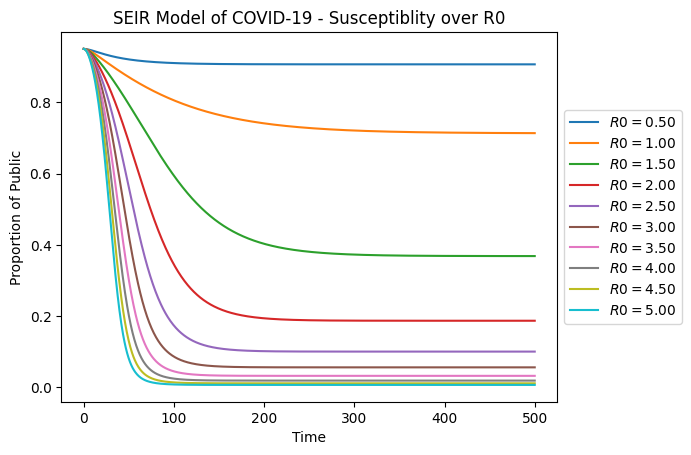

In [13]:
fig, ax = plt.subplots() ## Defines the subplot

for path, label in zip(s_paths, labels): ## Allows to loop through both the paths and labels at the same time
    ax.plot(t_vec, path, label=label) ## Plots the path line and corresponding label 
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Public")
    ax.set_title('SEIR Model of COVID-19 - Susceptiblity over R0')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) ## Adds the legend to the right
plt.savefig('R0_plot_S')
plt.show() ## Shows the plot


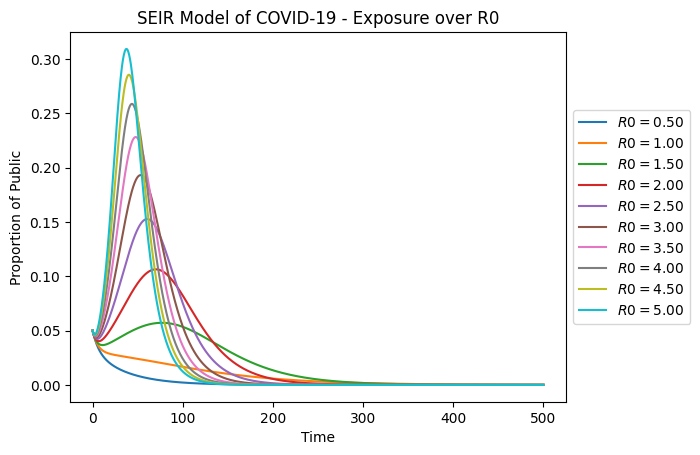

In [14]:
fig, ax = plt.subplots() ## Defines the subplot

for path, label in zip(e_paths, labels): ## Allows to loop through both the paths and labels at the same time
    ax.plot(t_vec, path, label=label) ## Plots the path line and corresponding label 
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Public")
    ax.set_title('SEIR Model of COVID-19 - Exposure over R0')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) ## Adds the legend to the right

plt.savefig('R0_plot_E')
plt.show() ## Shows the plot


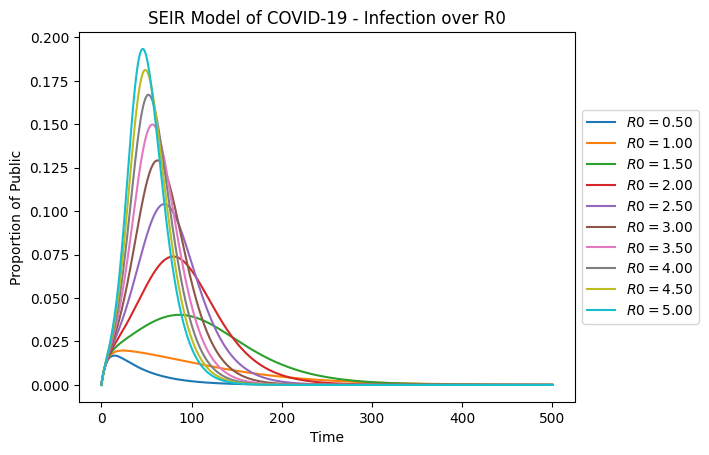

In [15]:
fig, ax = plt.subplots() ## Defines the subplot

for path, label in zip(i_paths, labels): ## Allows to loop through both the paths and labels at the same time
    ax.plot(t_vec, path, label=label) ## Plots the path line and corresponding label 
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Public")
    ax.set_title('SEIR Model of COVID-19 - Infection over R0')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) ## Adds the legend to the right
plt.savefig('R0_plot_I')
plt.show() ## Shows the plot


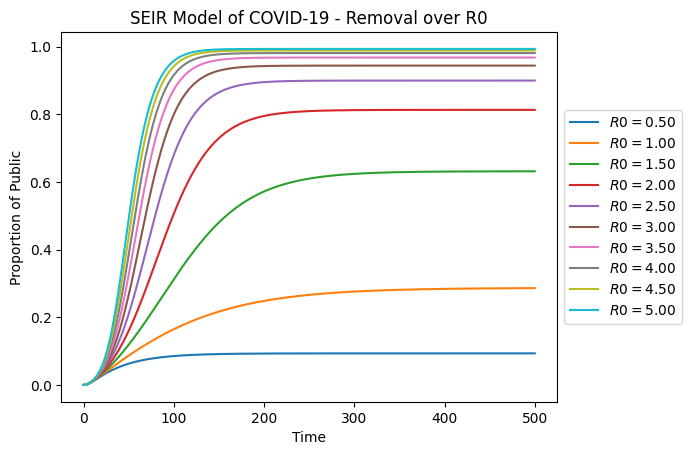

In [16]:
fig, ax = plt.subplots() ## Defines the subplot

for path, label in zip(r_paths, labels): ## Allows to loop through both the paths and labels at the same time
    ax.plot(t_vec, path, label=label) ## Plots the path line and corresponding label 
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Public")
    ax.set_title('SEIR Model of COVID-19 - Removal over R0')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) ## Adds the legend to the right
plt.savefig('R0_plot_R')
plt.show() ## Shows the plot


In [17]:
def plot_loop(index): ## Defines function to plot all components of each R0 SEIR on one plot
    
    for i in range(len(index)): ## Loops through each test for the R0 experiment
        plt.plot(t_vec, s_paths[i], label = "Susceptable") ## Plots the S over the T for a given index
        plt.plot(t_vec, e_paths[i], label = "Exposed") ## Plots the E over the T for a given index
        plt.plot(t_vec, i_paths[i], label = "Infected") ## Plots the I over the T for a given index
        plt.plot(t_vec, r_paths[i], label = "Removed") ## Plots the R over the T for a given index
        plt.plot(t_vec, c_paths[i], label = "Cumulative") ## Plots the R over the T for a given index
        plt.plot(t_vec, totals[i], 'c--', label = "Total")
        plt.legend() ## Adds a legend where it will fit
        plt.xlabel('Time')
        plt.ylabel('Proportion of Public')
        
        plt.title('SEIR Model of COVID-19 with an R Value of '+ str(R0_vals[i])) 
        ## Creates title and adds the corresponding R0 value from the given index
        plt.savefig('R0_SEIR_' + str(R0_vals[i])+'.png') ## Saves the image and adds the R0 to the file name        
        plt.show() ## Shows the plot


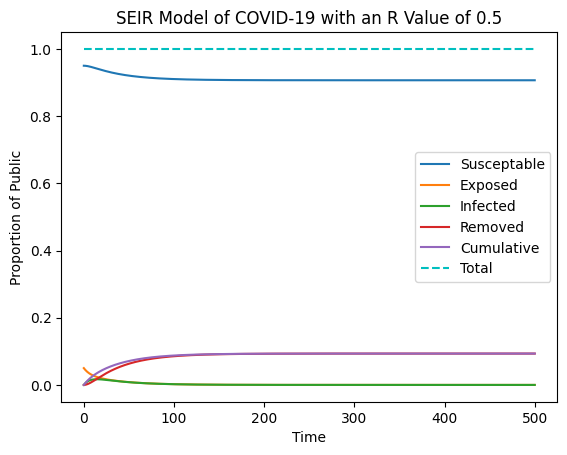

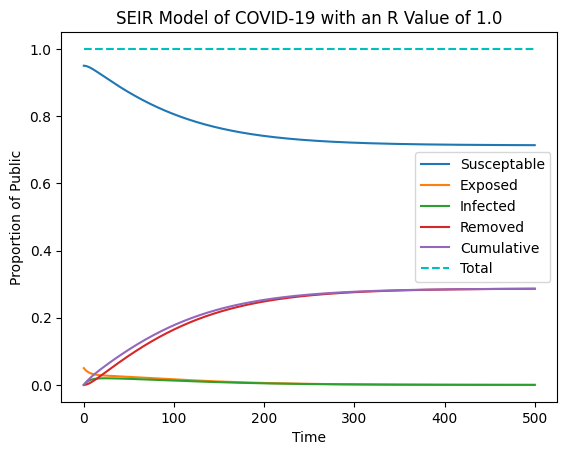

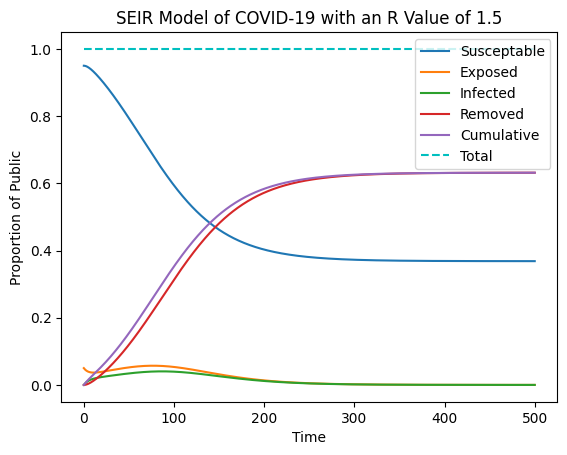

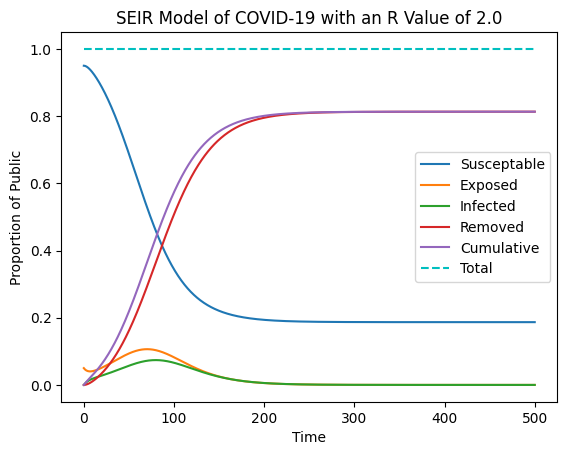

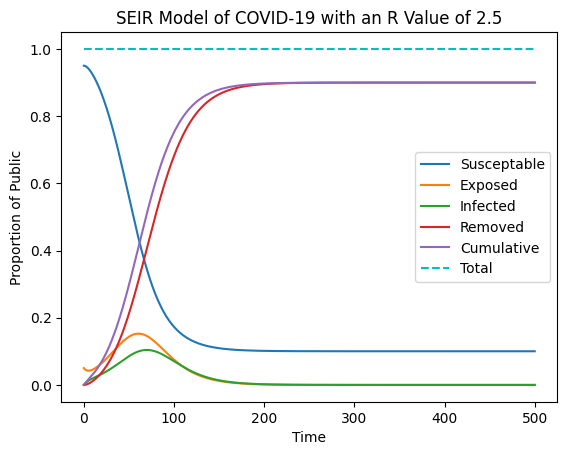

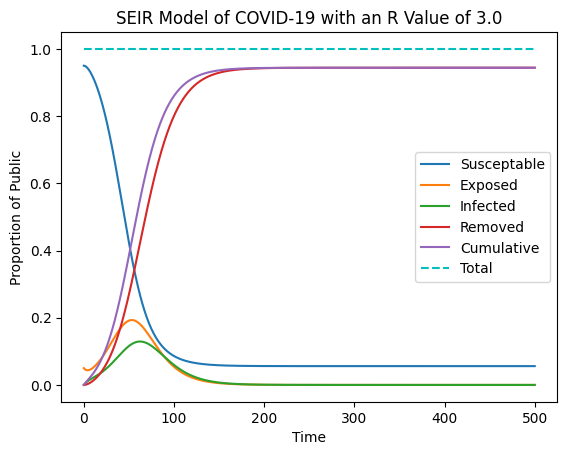

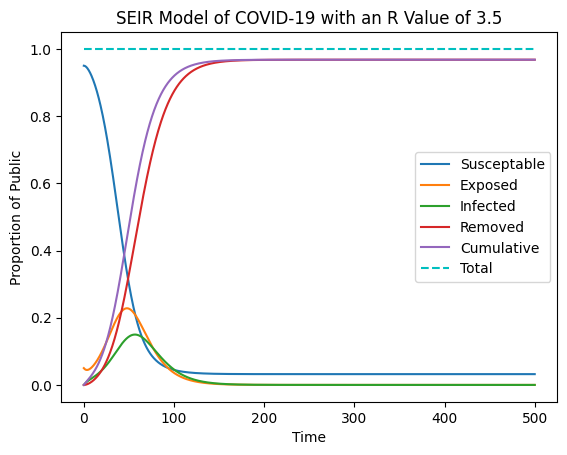

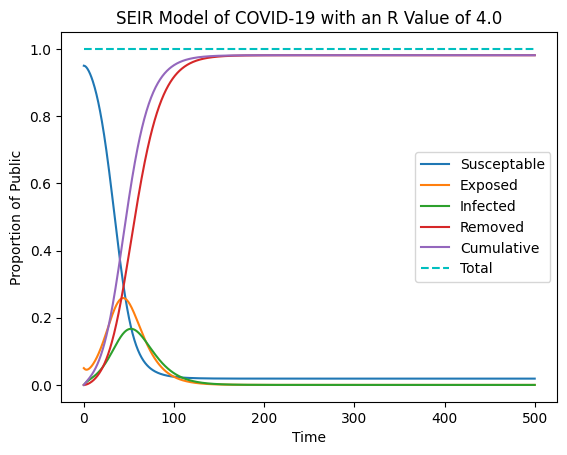

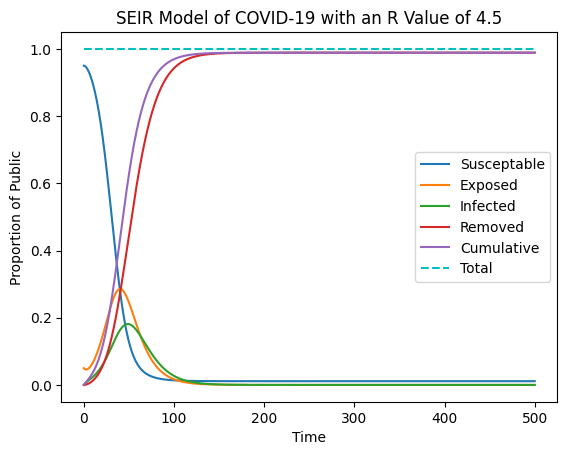

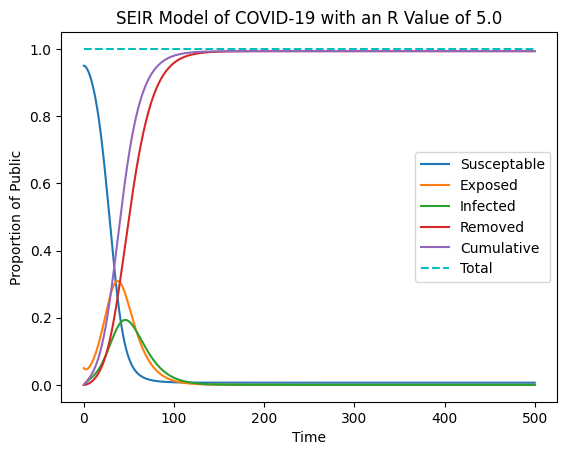

In [18]:
plot_loop(R0_vals) ## Loops through all R0 experiments from above and plots all SEIR lines on one plot

## Changing values of E

Here I decided to put all the code into one function, calculating the differentials based on an inputted array of E probabilities. This function outputs n graphs (based on the array length), showing the SEIR compartmented model based on the users E array.

In [19]:
def e_SEIR(e_array):
    population = 10000 ## Population of 1000 'nodes'
    gamma = 1/10 ## The recovery rate, at which point nodes recover or die (removed from the pool)
    sigma = e_array ## The percentage that someone will be exposed but not infectious
    R0 = 2 ## R-value - Transmission from one infected person to 'n' others

    
    for e_value in e_array: ## Loops through all E values in the array e_array
        def SEIR(x, t, R0): ## Defines SEIR function as seen above, but uses the e_value from the e_array
            
            s, e, i = x

            # New exposure of susceptibles
            beta = R0 * gamma ## Beta is calculated here
            ne = beta * s * i

            ds = - ne
            de = ne - e_value * e
            di = e_value * e - gamma * i

            return ds, de, di
                
        ## Starting parameters

        i_0 = 0.0
        e_0 = 0.05
        s_0 = 1 - i_0 - e_0
        x_0 = s_0, e_0, i_0
        
        t_length = 1000
        instances = 1000
        t_vec = np.linspace(0, t_length, instances)
        
        def solve_path(R0, t_vec, x_init=x_0): ## Defines the solve function as seen above

            G = lambda x, t: SEIR(x, t, R0)
            s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()
            c_path = 1 - s_path - e_path     
            r_path = 1 - s_path - e_path - i_path
            total = s_path + e_path + i_path + r_path
            return i_path, c_path, s_path, e_path, r_path, total
        
        i_path, c_path, s_path, e_path, r_path, total = solve_path(R0, t_vec, x_init=x_0)
        
    
        plt.plot(t_vec, s_path, label = "Susceptable")
        plt.plot(t_vec, e_path, label = "Exposed")
        plt.plot(t_vec, i_path, label = "Infected")
        plt.plot(t_vec, r_path, label = "Removed")
        plt.plot(t_vec, c_path, label = "Cumulative Infections")
        plt.plot(t_vec, total, 'c--', label = "Total")
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Proportion of Public')
        plt.title('SEIR Model of COVID-19 with an E Value of ' + (str(round(e_value, 3))))
        plt.savefig('E_SEIR_'+str(round(e_value, 3))+'.png') ## Saves and adds the E to the file name
        plt.show()
        

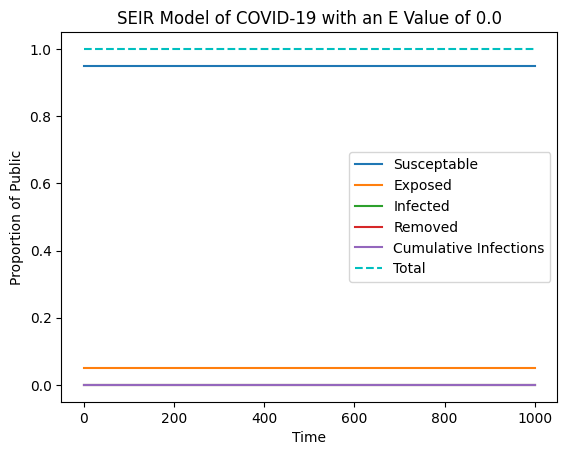

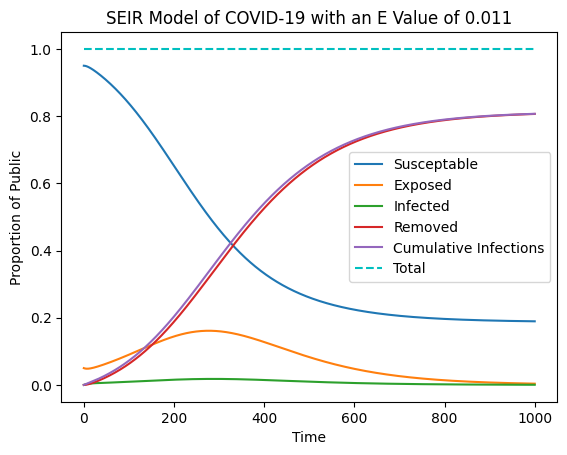

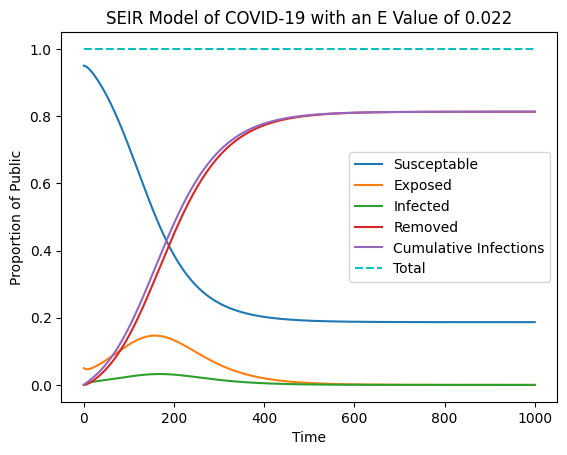

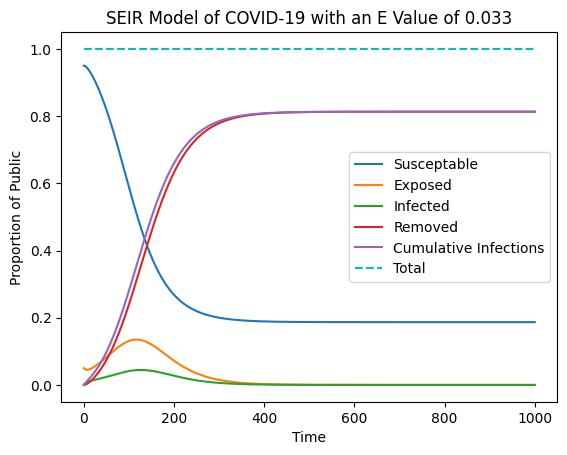

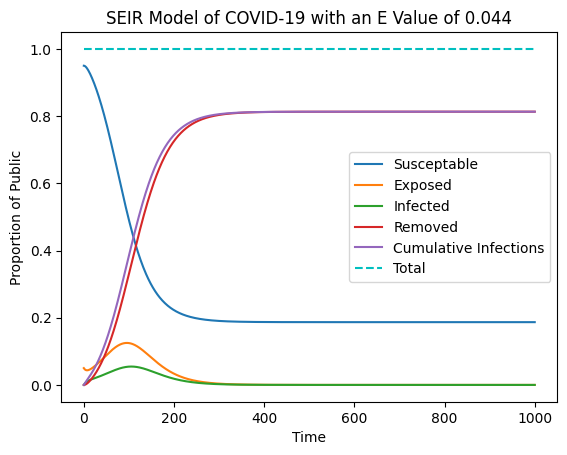

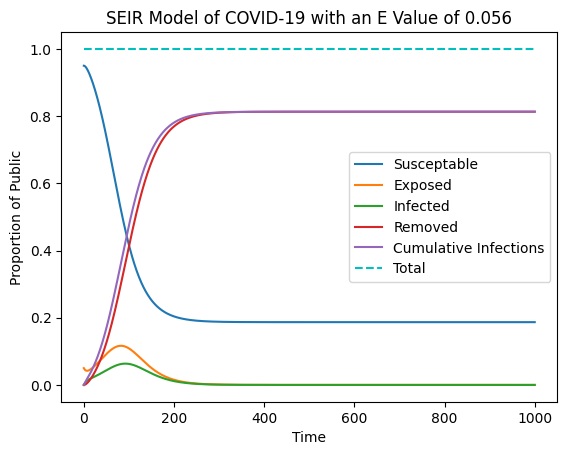

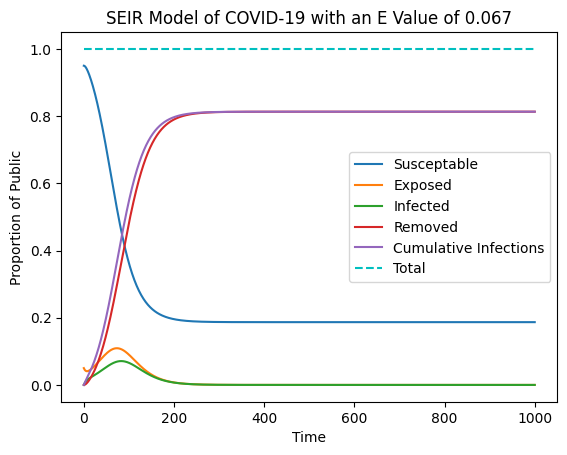

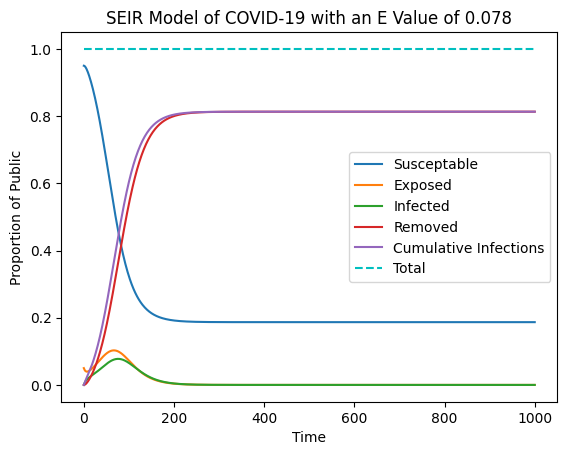

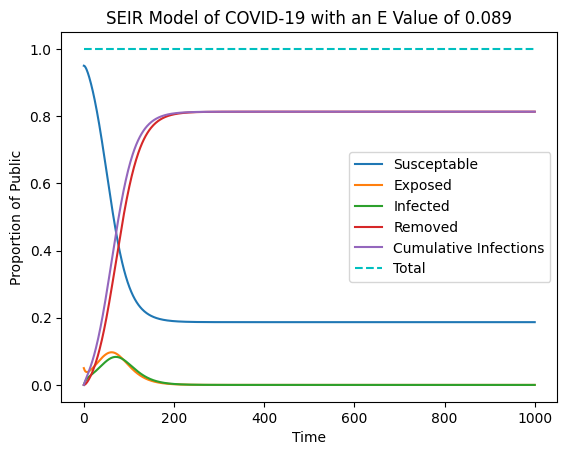

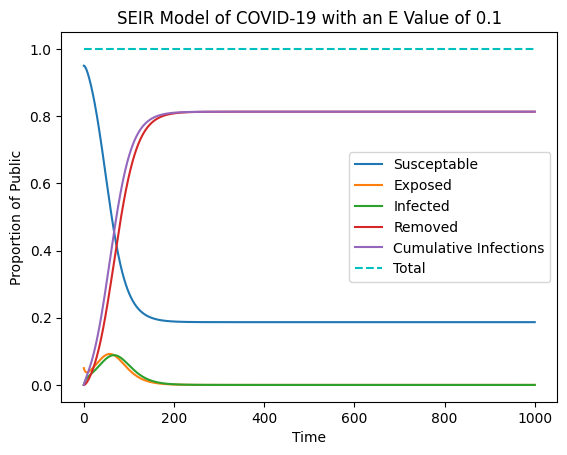

In [20]:
e_array = np.linspace(0, 0.1, 10)
e_SEIR(e_array)

In [21]:
def lockdown_SEIR(lockdown_array):
    population = 10000 ## Population of 1000 'nodes'
    gamma = 0.1 ## The recovery rate, at which point nodes recover or die (removed from the pool)
    sigma = 0.05 ## The rate that someone exposed will become infected
    R0 = 2 ## R-value - Transmission from one infected person to 'n' others
    

    
    for value in lockdown_array: ## Loops through all E values in the array e_array
        def SEIR(x, t, R0): ## Defines SEIR function as seen above, but uses the e_value from the e_array
            
            s, e, i = x

            # New exposure of susceptibles
            beta = R0 * gamma ## Beta is calculated here, the rate at which someone is exposed.
            ne = beta * s * i

            ds = - (1-value) * ne
            de = (1-value) * ne - sigma * e
            di = sigma * e - gamma * i

            return ds, de, di
                
        ## Starting parameters

        i_0 = 0.0
        e_0 = 0.05
        s_0 = 1 - i_0 - e_0
        x_0 = s_0, e_0, i_0
        
        t_length = 1000
        instances = 1000
        t_vec = np.linspace(0, t_length, instances)
        
        def solve_path(R0, t_vec, x_init=x_0): ## Defines the solve function as seen above

            G = lambda x, t: SEIR(x, t, R0)
            s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()
            c_path = 1 - s_path - e_path     
            r_path = 1 - s_path - e_path - i_path
            total = s_path + e_path + i_path + r_path
            return i_path, c_path, s_path, e_path, r_path, total
        
        i_path, c_path, s_path, e_path, r_path, total = solve_path(R0, t_vec, x_init=x_0)
        
    
        plt.plot(t_vec, s_path, label = "Susceptable")
        plt.plot(t_vec, e_path, label = "Exposed")
        plt.plot(t_vec, i_path, label = "Infected")
        plt.plot(t_vec, r_path, label = "Removed")
        plt.plot(t_vec, c_path, label = "Cumulative Infections")
        plt.plot(t_vec, total, 'c--', label = "Total")
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Proportion of Public')
        plt.title('SEIR Model of COVID-19 with a lockdown Value of ' + (str(round(value, 2))))
        plt.savefig('Lockdown_SEIR_'+str(value)+'.png') ## Saves image and adds the lockdown to the file name
        plt.show()

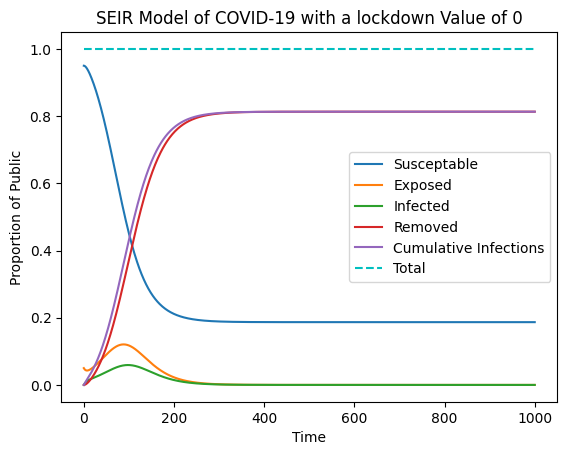

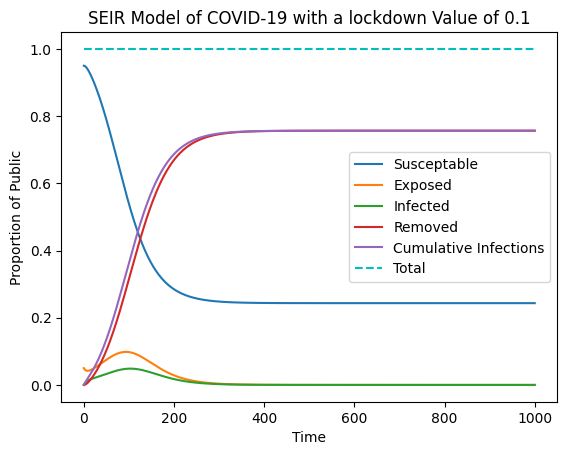

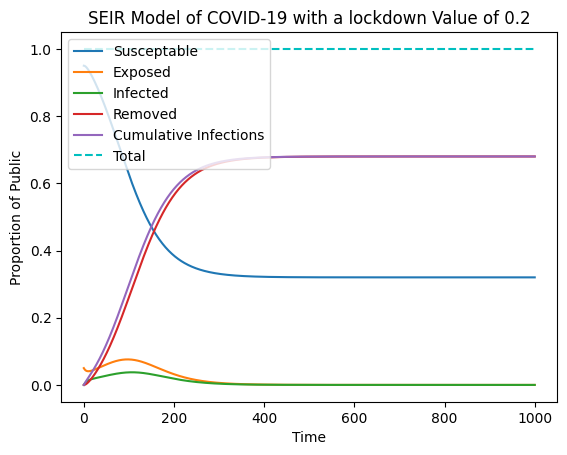

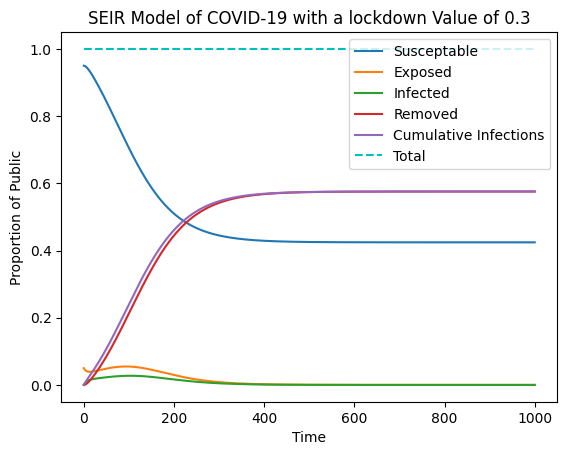

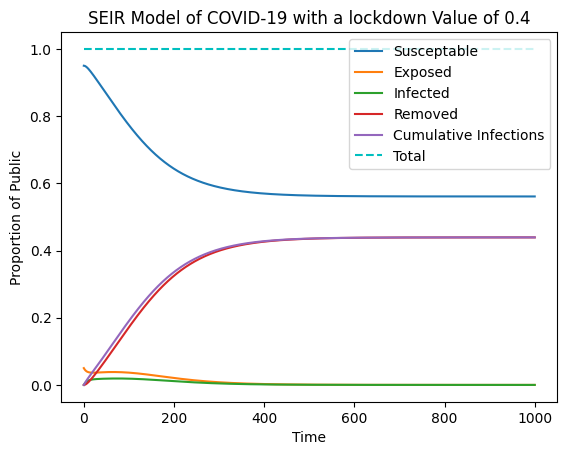

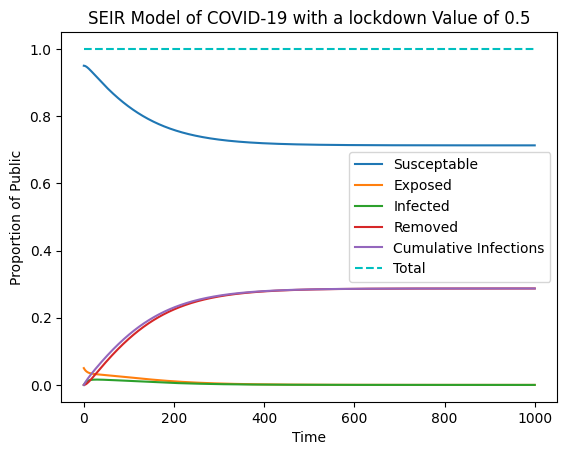

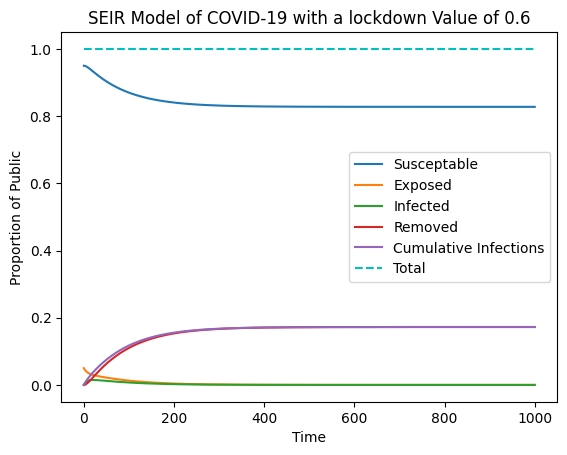

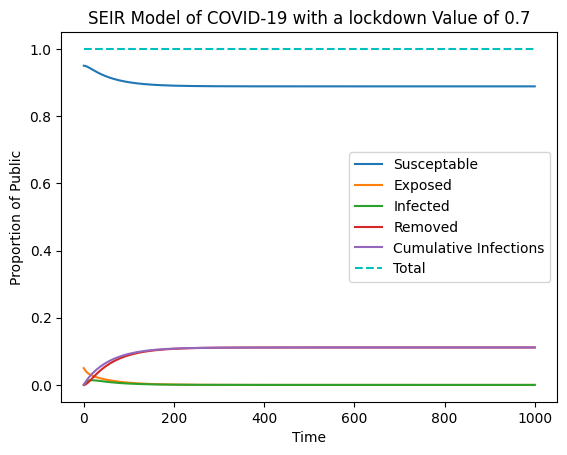

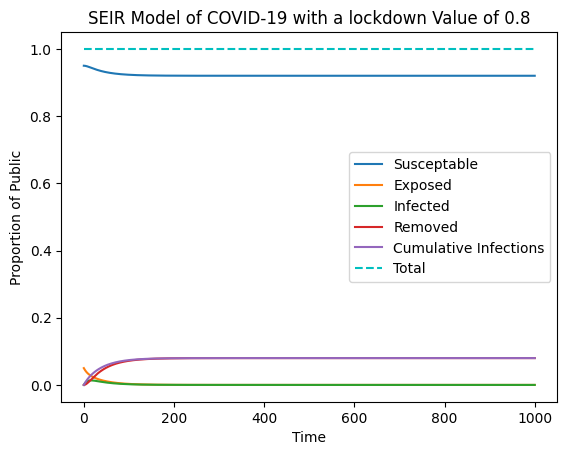

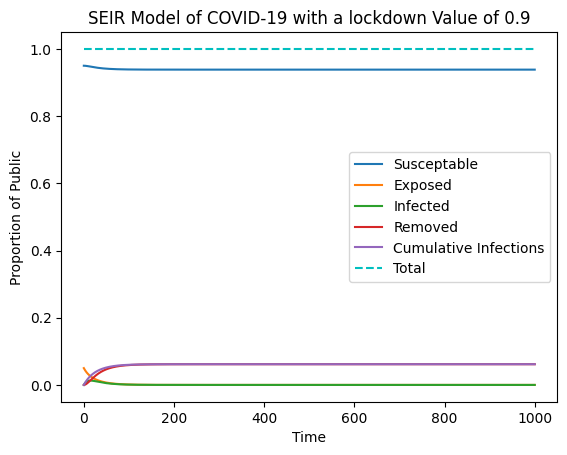

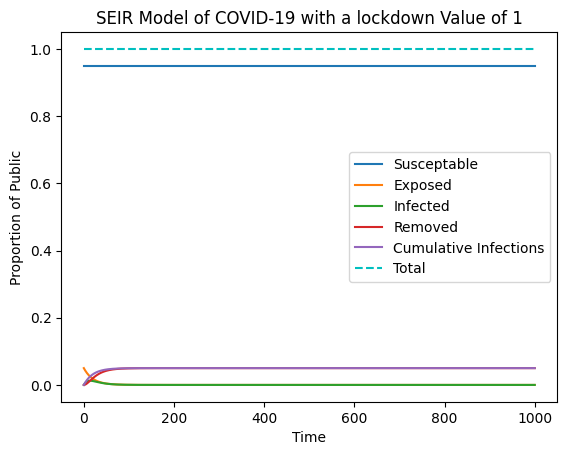

In [22]:
lockdown_array = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lockdown_SEIR(lockdown_array)